# Trabajo Final <br>
Nombre: Lautaro Ochotorena <br>
DNI: 41542924 <br>
Carrera: Licenciatura en Matemáticas

In [ ]:
# Se debe instalar ya que no la posee Collab
!pip install torchview

In [ ]:
# Librerías que se usarán
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import random
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import copy
from sklearn.metrics import confusion_matrix
from torchview import draw_graph

In [ ]:
# Usa la gpu cuando esté habilitada
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ¿Qué está utilizando actualemente?
device

'cuda'

**Reproducibility** <br>
ML experiments may be very hard to reproduce. You have a lot of hyperparameters, different dataset splits, different ways to preprocess your data, bugs, etc. Ideally, you should log data split (already preprocessed), all hyperparameters (including learning rate scheduling), the initial state of your model and optimizer, random seeds used for initialization, dataset shuffling and all of your code. Your GPU is also should be in deterministic mode (which is not the default mode). For every single model run. This is a very hard task. Different random seed can significantly change your metrics and even GPU-induced randomness can be important. We're not solving all of these problems, but we need to address at least what we can handle.

In [ ]:
# Para reproducibilidad
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

## Parte 1: Red Nueronal Autoencoder

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Descargar los datasets
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
validset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 16094618.81it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271052.62it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5061480.97it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2554694.39it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [ ]:
class CustomDataset_autoencoder(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image
        return input,output

In [ ]:
# Hacemos que los datasets tengan el formato de la clase definida antes
train_set = CustomDataset_autoencoder(trainset)
valid_set = CustomDataset_autoencoder(validset)

In [ ]:
def descomprimir(x):
 return x.unsqueeze(0)   #(28,28)----> (1,28,28)
# Si al modelo le doy (28,28) no lo entiende, necesita el 1 porque necesita saber de la primer dimension para saber que imagen del lote es
"una imagen desloteada la pasa a formalo lote para q el modelo la use"

def comprimir(x):
  return x.squeeze().detach().cpu().numpy()  #(1,28,28)---> (28,28) esto nos sirve para sacar la dimension del lote y nos lo copia a cpu y lo pasa numpy para poder graficar ("deslotea")

In [ ]:
# Arquitectura de la red
class NeuralNetwork_autoencoder(nn.Module):
  def __init__(self, n, p=0.2, name='Modelo'):

    # Guardo atributos para saber reconocer al modelo
    self.n = n
    self.name= name

    # Atributos para ir guarando cómo se comporta la loss después de entrenar
    self.train_avg_loss_entrenamiento = []
    self.train_avg_loss_entrenada = []
    self.valid_avg_loss = []

    # Guardo los pesos por época
    self.pesos_por_epoca = {}

    # Ya hay una clase creada por pytorch y le tengo que heredar los métodos con este super, agregamos atributos (o miembros) que viene de métodos de la superclase
    super(NeuralNetwork_autoencoder, self).__init__()

    # Encoder
    self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3)),  # input = 1x28x28, output = 16x26x26
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(kernel_size=(2, 2)), # output = 16x13x13

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3)), # output = 32x11x11
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(kernel_size=(2, 2)), # output = 32x5x5

            nn.Flatten(start_dim=1),  # output = 32*5*5
            nn.Linear(32*5*5, n),  # output = n
            nn.ReLU(),
            nn.Dropout(p),
        )

    # Decoder
    self.decoder = nn.Sequential(
            nn.Linear(n, 32*5*5), # output = 32*5*5
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(dim=1 ,unflattened_size=(32, 5, 5)), # output = 32x5x5

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(4, 4), stride=(2, 2), output_padding=(1,1)), # output = 16x13x13
            nn.ReLU(),
            nn.Dropout(p),

            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1,1)),  # output = 1x28x28, output_padding doesn't pad zeros or anything to output, it is just a way
                                                                                                                          #to determine the output shape and apply transpose convolution accordingly.
            nn.Sigmoid(),
        )

  # Pasos de la arquitectura
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  # Visualización de ejemplos del autoencoder
  def visualizacion(self, dataset, rows=3):
    # Seleccionamos el método eval para que desactive el dropout
    self.eval()
    # Mandamos el modelo para que actué en el entorno adecuado
    self.to(device)

    # Creación de la figura
    figure = plt.figure()
    plt.suptitle(f'{self.name}')
    for i in range(rows):
      # Toma un ejemplo aleatorio del dataset
      j = torch.randint(len(dataset),size=(1,)).item()
      image = comprimir(dataset[j][0])

      # Imagen original
      figure.add_subplot(rows, 2, 2*i+1)
      if i==0:
        plt.title('Original')
      plt.axis("off")
      plt.imshow(image, cmap="Greys_r")

      # Prediccion sin entrenar
      figure.add_subplot(rows, 2, 2*(i+1))
      model_image = descomprimir(dataset[j][0]).to(device)
      predict = comprimir(self(descomprimir(dataset[j][0]).to(device)))
      if i==0:
        plt.title('Autoencoder')
      plt.axis("off")
      plt.imshow(predict, cmap="Greys_r")

    # La guarda en el directorio
    plt.savefig(f'Ejemplo {self.name}.svg', bbox_inches='tight', pad_inches=0.1, format='svg')
    plt.show()

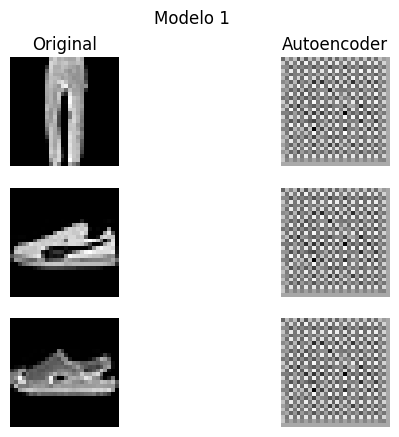

In [ ]:
# Creo el objeto que actuará como autoencoder
red_neuronal_autoencoder = NeuralNetwork_autoencoder(n=64, p=0.2, name='Modelo 1')
red_neuronal_autoencoder.visualizacion(dataset=valid_set)

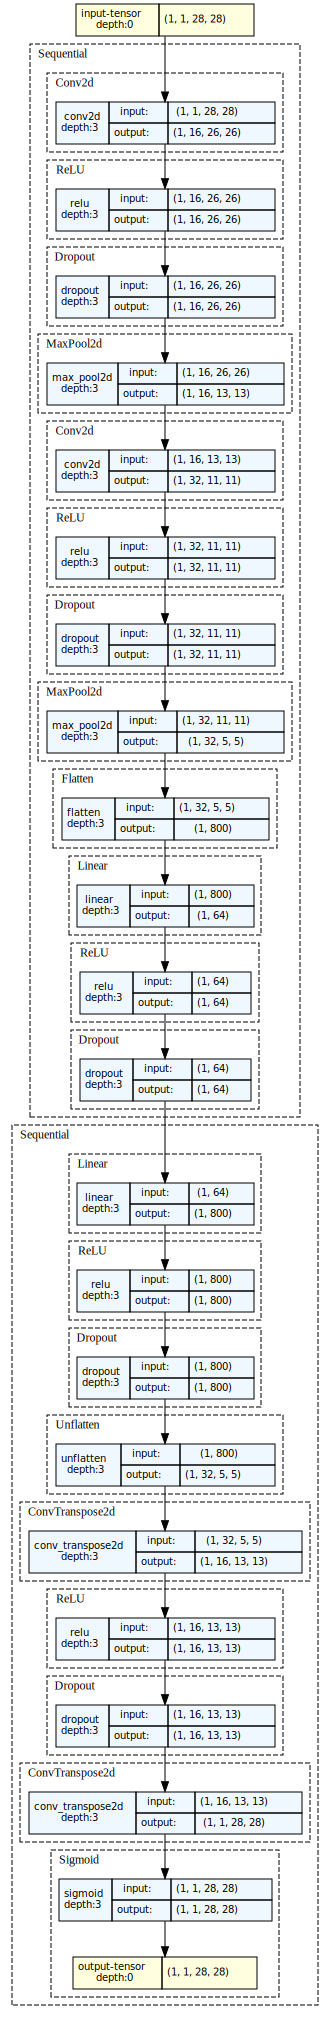

In [ ]:
# Visualización del modelo. Input_size = (1, 1, 28, 28) refiere a un ejemplo con dimensiones (1, 28, 28)
model_graph = draw_graph(model=red_neuronal_autoencoder, input_size=(1, 1, 28, 28), expand_nested=True,
                         device=device, hide_module_functions=False)
model_graph.visual_graph.render('estructura autoencoder', format='svg', view=True)
model_graph.visual_graph

## Parte 2: Entrenando el autoencoder

In [ ]:
def entrenamiento_epoca(model, trainloader, validloader, loss_fn, optimizer, num_epochs, verbose=1, accuracy=False, stopper=[5, 0.001]):  #stopper = [patience, increase]
  # Determinamos en que dispositivo vamos a trabajar, CPU o GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # Pasamos el modelo al dispositivo
  model = model.to(device)
  # Establecemos parámetros para el Early Stopper
  counter = 0
  prev_val_loss = float('inf')

  # Entrenamiento por época
  for epoch in range(1,num_epochs+1):
    if verbose == 1:
      print(f"Epoch {epoch}\n-------------------------------")
    if accuracy:
      train_avg_loss_entrenamiento_epoc, train_frac_correct_entrenamiento_epoc = train_loop(trainloader, model, loss_fn, optimizer, verbose, accuracy)
      train_avg_loss_entrenada_epoc, train_frac_correct_entrenada_epoc = valid_loop(trainloader, model, loss_fn, verbose, conj_entrenamiento=True, accuracy=accuracy)
      valid_avg_loos_epoc, valid_frac_correct_epoc = valid_loop(validloader, model, loss_fn, verbose, accuracy=accuracy)

      # Guardo cada frac en las listas creadas como atributos del modelo con accuracy
      model.train_frac_correct_entrenamiento.append(train_frac_correct_entrenamiento_epoc)
      model.train_frac_correct_entrenada.append(train_frac_correct_entrenada_epoc)
      model.valid_frac_correct.append(valid_frac_correct_epoc)
    else:
      train_avg_loss_entrenamiento_epoc = train_loop(trainloader, model, loss_fn, optimizer, verbose, accuracy)
      train_avg_loss_entrenada_epoc = valid_loop(trainloader, model, loss_fn, verbose, conj_entrenamiento=True, accuracy=accuracy)
      valid_avg_loos_epoc  = valid_loop(validloader, model, loss_fn, verbose, accuracy)

    # Verificar si la pérdida en validación ha dejado de disminuir o disminuye muy poco
    if valid_avg_loos_epoc >= prev_val_loss-stopper[1]:
      counter += 1
      if counter >= stopper[0]:
        print(f'Early stopping at epoch {epoch}, restored from {stopper[0]} epochs back')

        # Me quedo con los valores de lo que pasó hace stopper[0] (patience) épocas atrás
        model.train_avg_loss_entrenamiento = model.train_avg_loss_entrenamiento[:-stopper[0]+1]
        model.train_avg_loss_entrenada = model.train_avg_loss_entrenada[:-stopper[0]+1]
        model.valid_avg_loss = model.valid_avg_loss[:-stopper[0]+1]

        if accuracy:
          model.train_frac_correct_entrenamiento = model.train_frac_correct_entrenamiento[:-stopper[0]+1]
          model.train_frac_correct_entrenada = model.train_frac_correct_entrenada[:-stopper[0]+1]
          model.valid_frac_correct = model.valid_frac_correct[:-stopper[0]+1]

        # Rompo el loop
        break
    else:
        prev_val_loss = valid_avg_loos_epoc
        counter = 0

    # Guardar los pesos de cada época
    model.pesos_por_epoca[epoch] = model.state_dict().copy()
    # Guardo cada errores en las listas creadas como atributos del modelo
    model.train_avg_loss_entrenamiento.append(train_avg_loss_entrenamiento_epoc)
    model.train_avg_loss_entrenada.append(train_avg_loss_entrenada_epoc)
    model.valid_avg_loss.append(valid_avg_loos_epoc)
  print("¡Listo!")

def train_loop(dataloader,model,loss_fn,optimizer, verbose=1, accuracy=False):
  # Activamos la maquinaria de entrenamiento del modelo para poder aplicar gradientes
  model.train()
  # Definimos ciertas constantes
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss,sum_correct = 0,0
  # Iteramos sobre lotes
  for batch, (X, y) in enumerate(dataloader):
      # Copiamos las entradas y las salidas al dispositivo de trabajo
      X = X.to(device)
      y = y.to(device)
      # Calculamos la predicción del modelo y la correspondiente pérdida (error)
      pred = model(X)           # Da un lote de valores pred
      loss = loss_fn(pred,y)    # Hacemos los errores en el lote, es un número como vector de pytorch
      # Backpropagamos usando el optimizador proveido.
      optimizer.zero_grad() # Setea a 0 los valores de los gradientes
      loss.backward()   # Ahora los calcula
      optimizer.step()  # Usa los valores de los gradientes para actualizar los pesos
      # Sumamos la pérdida al total de la época
      loss_value = loss.item()  # Obtenemos el número sólo
      sum_loss += loss_value

      if accuracy:
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item() # Suma cuántas etiquetes fueron clasificadas correctamente en el lote

      # Imprimimos el progreso
      if batch % int(1/4*num_batches) == 0 and verbose == 1:    # Imprime 4 batchs, cuando va por el 0%,25%,50% y 75%
          current = batch*len(X)
          print(f"batch={batch} loss={loss_value:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")

  # Toma la pérdida promedio de la época
  avg_loss = sum_loss/num_batches

  # Outputs
  if accuracy:
    frac_correct = sum_correct/size
    return avg_loss,frac_correct
  else:
    return avg_loss

def valid_loop(dataloader, model, loss_fn, verbose, conj_entrenamiento=False, accuracy=False):
  # Desactivamos la maquinaria de entrenamiento del modelo, no aplica gradientes y desacativa dropout
  model.eval()
  # Definimos ciertas constantes
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss,sum_correct = 0,0
  # Para testear, desactivamos el cálculo de gradientes.
  with torch.no_grad():
      # Iteramos sobre lotes
      for X,y in dataloader:
          # Copiamos las entradas y las salidas al dispositivo de trabajo
          X = X.to(device)
          y = y.to(device)
          # Calculamos las predicciones del modelo
          pred = model(X)
          # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total
          sum_loss += loss_fn(pred,y).item()
          if accuracy:
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  # Calculamos la pérdida total y la fracción de clasificaciones correctas
  avg_loss = sum_loss/num_batches

  # Según el caso se imprime lo correspondiente
  if accuracy and conj_entrenamiento == False and verbose == 1:
    frac_correct = sum_correct/size
    print(f"Valid Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
  elif accuracy and conj_entrenamiento and verbose == 1:
    frac_correct = sum_correct/size
    print(f"Training Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
  elif accuracy == False and conj_entrenamiento == False and verbose == 1:
    print(f"Valid Error: \n Avg loss: {avg_loss:>8f} \n")
  elif accuracy == False and conj_entrenamiento and verbose == 1:
    print(f"Training Error: \n Avg loss: {avg_loss:>8f} \n")

  # Outputs
  if accuracy == False:
    return avg_loss
  else:
    return avg_loss,frac_correct

In [ ]:
def grafico_error(list_models):
  # Etiqueta para el nombre de la imagen
  etiqueta_savefig = 'error'

  # Paleta de colores para las curvas
  paleta_colores_train = sns.color_palette("bright")
  paleta_colores_valid = sns.color_palette("husl", 8)

  # Curva de los errores
  for i in range(len(list_models)):
    plt.plot(range(1,len(list_models[i].train_avg_loss_entrenada)+1), list_models[i].train_avg_loss_entrenada,
            label=f"train error {list_models[i].name}", linestyle='-', c=paleta_colores_train[i], linewidth=2.5)

    plt.plot(range(1,len(list_models[i].valid_avg_loss)+1), list_models[i].valid_avg_loss,
            label=f"valid error {list_models[i].name}", linestyle='--', c=paleta_colores_valid[i], linewidth=2.5)

    # Agrego los modelos involucrados a la etiqueta
    etiqueta_savefig += f' {list_models[i].name}'

  etiqueta_savefig += '.svg'
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(etiqueta_savefig, bbox_inches='tight', pad_inches=0.1, format='svg')
  plt.show()

def grafico_accuracy(list_models):
  # etiqueta para el nombre de la imagen
  etiqueta_savefig = 'accuracy'

  # Paleta de colores para las curvas
  paleta_colores_entrenada = sns.color_palette("bright")
  paleta_colores_valid = sns.color_palette("husl", 8)

  # Curva del accuracy
  for i in range(len(list_models)):
    plt.plot(range(1,len(list_models[i].train_frac_correct_entrenada)+1), list_models[i].train_frac_correct_entrenada,
            label=f"train accuracy {list_models[i].name}", linestyle='-', c=paleta_colores_entrenada[i], linewidth=2.5)

    plt.plot(range(1,len(list_models[i].valid_frac_correct)+1), list_models[i].valid_frac_correct,
            label=f"valid accuracy {list_models[i].name}", linestyle='--', c=paleta_colores_valid[i], linewidth=2.5)

    # agrego los modelos involucrados a la etiqueta
    etiqueta_savefig += f' {list_models[i].name}'

  etiqueta_savefig += '.svg'
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.savefig(etiqueta_savefig, bbox_inches='tight', pad_inches=0.1, format='svg')
  plt.show()

In [ ]:
# Creamos los DataLoaders
batch_size = 100
trainloader = DataLoader(train_set , batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle = False)  # No es necesario hacer shuffle ya que el error total no depende de cómo se repartan los batchs

# Optimizador
learning_rate = 1e-3
optimizer = torch.optim.Adam(red_neuronal_autoencoder.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

# Loss function, error cuadrático medio
loss_fn = nn.MSELoss()

# Número de épocas
num_epochs = 40
entrenamiento_epoca(red_neuronal_autoencoder, trainloader, valid_loader, loss_fn, optimizer, num_epochs, verbose=1)

Epoch 1
-------------------------------
batch=0 loss=0.141545  muestras-procesadas:[    0/60000]
batch=150 loss=0.056941  muestras-procesadas:[15000/60000]
batch=300 loss=0.048834  muestras-procesadas:[30000/60000]
batch=450 loss=0.049042  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.045111 

Valid Error: 
 Avg loss: 0.045146 

Epoch 2
-------------------------------
batch=0 loss=0.046325  muestras-procesadas:[    0/60000]
batch=150 loss=0.041954  muestras-procesadas:[15000/60000]
batch=300 loss=0.041073  muestras-procesadas:[30000/60000]
batch=450 loss=0.040189  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.042468 

Valid Error: 
 Avg loss: 0.042516 

Epoch 3
-------------------------------
batch=0 loss=0.041317  muestras-procesadas:[    0/60000]
batch=150 loss=0.041041  muestras-procesadas:[15000/60000]
batch=300 loss=0.041790  muestras-procesadas:[30000/60000]
batch=450 loss=0.042451  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 

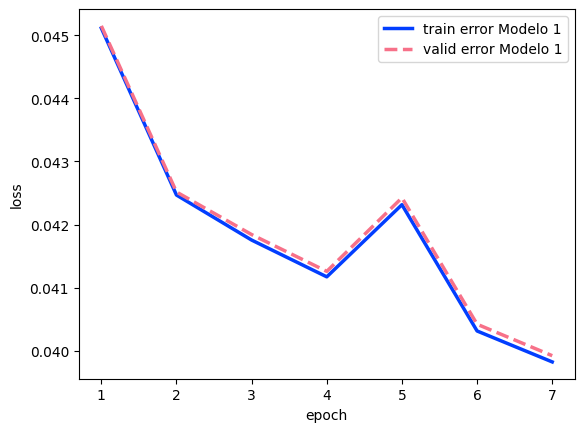

In [ ]:
grafico_error(list_models=[red_neuronal_autoencoder])

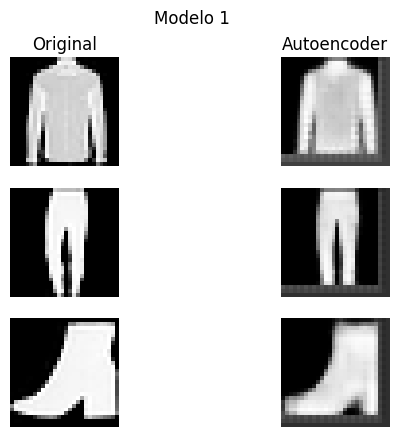

In [ ]:
red_neuronal_autoencoder.visualizacion(dataset=valid_set)

## Modelo 2 Autoencoder

In [ ]:
# Creo el objeto que actuará como autoencoder
red_neuronal_autoencoder_2 = NeuralNetwork_autoencoder(n=256, p=0.3, name='Modelo 2')

In [ ]:
# Creamos los DataLoaders
batch_size = 1000
trainloader = DataLoader(train_set , batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle = False)  # No es necesario hacer shuffle ya que el error total no depende de cómo se repartan los batchs

# Optimizador
learning_rate = 1e-3
optimizer = torch.optim.Adam(red_neuronal_autoencoder_2.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

# Loss function, error cuadrático medio
loss_fn = nn.MSELoss()

# Número de épocas
num_epochs = 40
entrenamiento_epoca(red_neuronal_autoencoder_2, trainloader, valid_loader, loss_fn, optimizer, num_epochs, verbose=1)

Epoch 1
-------------------------------
batch=0 loss=0.203567  muestras-procesadas:[    0/60000]
batch=15 loss=0.147240  muestras-procesadas:[15000/60000]
batch=30 loss=0.123859  muestras-procesadas:[30000/60000]
batch=45 loss=0.108553  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.096564 

Valid Error: 
 Avg loss: 0.096233 

Epoch 2
-------------------------------
batch=0 loss=0.098919  muestras-procesadas:[    0/60000]
batch=15 loss=0.090971  muestras-procesadas:[15000/60000]
batch=30 loss=0.085630  muestras-procesadas:[30000/60000]
batch=45 loss=0.080488  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.077593 

Valid Error: 
 Avg loss: 0.077376 

Epoch 3
-------------------------------
batch=0 loss=0.077705  muestras-procesadas:[    0/60000]
batch=15 loss=0.075557  muestras-procesadas:[15000/60000]
batch=30 loss=0.073806  muestras-procesadas:[30000/60000]
batch=45 loss=0.071039  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.069164 

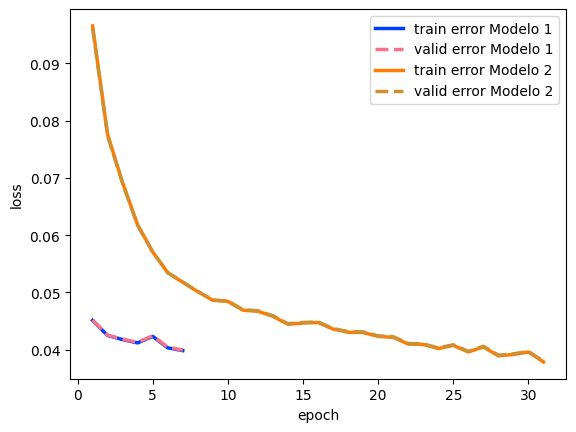

In [ ]:
grafico_error(list_models=[red_neuronal_autoencoder, red_neuronal_autoencoder_2])

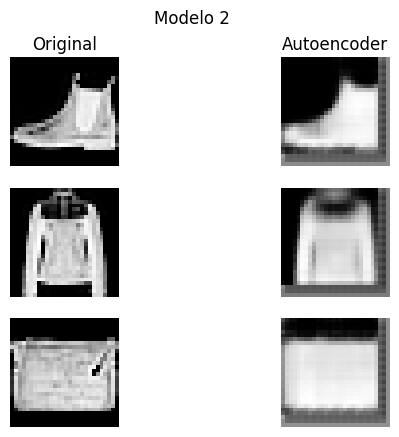

In [ ]:
red_neuronal_autoencoder_2.visualizacion(dataset=valid_set)

## Modelo 3 Autoencoder

In [ ]:
# Creo el objeto que actuará como autoencoder
red_neuronal_autoencoder_3 = NeuralNetwork_autoencoder(n=64, p=0.3, name='Modelo 3')

In [ ]:
# Creamos los DataLoaders
batch_size = 1000
trainloader = DataLoader(train_set , batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle = False)  # No es necesario hacer shuffle ya que el error total no depende de cómo se repartan los batchs

# Optimizador
learning_rate = 1e-2
optimizer = torch.optim.SGD(red_neuronal_autoencoder_3.parameters(),lr=learning_rate)

# Loss function, error cuadrático medio
loss_fn = nn.MSELoss()

# Número de épocas
num_epochs = 40
entrenamiento_epoca(red_neuronal_autoencoder_3, trainloader, valid_loader, loss_fn, optimizer, num_epochs, verbose=1)

Epoch 1
-------------------------------
batch=0 loss=0.154408  muestras-procesadas:[    0/60000]
batch=15 loss=0.153279  muestras-procesadas:[15000/60000]
batch=30 loss=0.153000  muestras-procesadas:[30000/60000]
batch=45 loss=0.150949  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.149581 

Valid Error: 
 Avg loss: 0.148918 

Epoch 2
-------------------------------
batch=0 loss=0.149282  muestras-procesadas:[    0/60000]
batch=15 loss=0.147126  muestras-procesadas:[15000/60000]
batch=30 loss=0.146381  muestras-procesadas:[30000/60000]
batch=45 loss=0.147734  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.145857 

Valid Error: 
 Avg loss: 0.145215 

Epoch 3
-------------------------------
batch=0 loss=0.145441  muestras-procesadas:[    0/60000]
batch=15 loss=0.144501  muestras-procesadas:[15000/60000]
batch=30 loss=0.143232  muestras-procesadas:[30000/60000]
batch=45 loss=0.143736  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.142769 

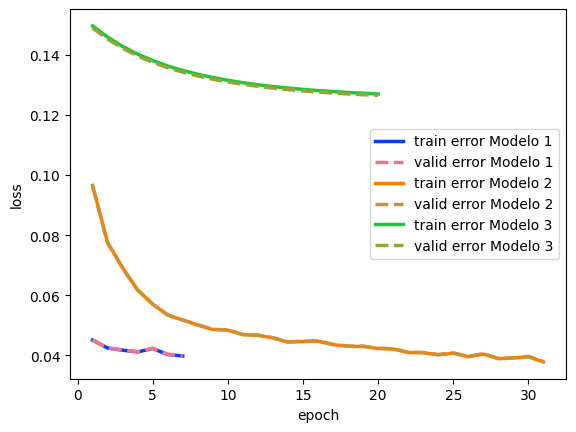

In [ ]:
grafico_error(list_models=[red_neuronal_autoencoder, red_neuronal_autoencoder_2, red_neuronal_autoencoder_3])

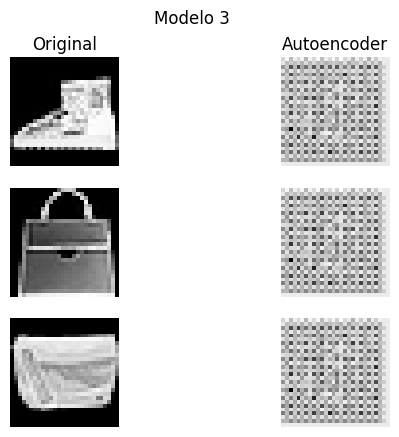

In [ ]:
red_neuronal_autoencoder_3.visualizacion(dataset=valid_set)

Un pésimo desempeño

## Modelo 4

In [ ]:
# Creo el objeto que actuará como autoencoder
red_neuronal_autoencoder_4 = NeuralNetwork_autoencoder(n=128, p=0.3, name='Modelo 4')

n=128
p=0.3
# Elimino el output_padding del ConvTranspose y agrego más kernel_size
red_neuronal_autoencoder_4.decoder = nn.Sequential(
            nn.Linear(n, 32*5*5), # output = 32*5*5
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(dim=1 ,unflattened_size=(32, 5, 5)), # output = 32x5x5

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(5, 5), stride=(2, 2)), # output = 16x13x13
            nn.ReLU(),
            nn.Dropout(p),

            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(4, 4), stride=(2, 2)),  # output = 1x28x28
            nn.Sigmoid(),
            )

In [ ]:
# Creamos los DataLoaders
batch_size = 1000
trainloader = DataLoader(train_set , batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle = False)  # No es necesario hacer shuffle ya que el error total no depende de cómo se repartan los batchs

# Optimizador
learning_rate = 1e-3
optimizer = torch.optim.Adam(red_neuronal_autoencoder_4.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

# Loss function, error cuadrático medio
loss_fn = nn.MSELoss()

# Número de épocas
num_epochs = 40
entrenamiento_epoca(red_neuronal_autoencoder_4, trainloader, valid_loader, loss_fn, optimizer, num_epochs, verbose=1)

Epoch 1
-------------------------------
batch=0 loss=0.157458  muestras-procesadas:[    0/60000]
batch=15 loss=0.119208  muestras-procesadas:[15000/60000]
batch=30 loss=0.088065  muestras-procesadas:[30000/60000]
batch=45 loss=0.067379  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.055673 

Valid Error: 
 Avg loss: 0.055518 

Epoch 2
-------------------------------
batch=0 loss=0.055080  muestras-procesadas:[    0/60000]
batch=15 loss=0.047229  muestras-procesadas:[15000/60000]
batch=30 loss=0.041749  muestras-procesadas:[30000/60000]
batch=45 loss=0.040250  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.039955 

Valid Error: 
 Avg loss: 0.039878 

Epoch 3
-------------------------------
batch=0 loss=0.037625  muestras-procesadas:[    0/60000]
batch=15 loss=0.036725  muestras-procesadas:[15000/60000]
batch=30 loss=0.035161  muestras-procesadas:[30000/60000]
batch=45 loss=0.034475  muestras-procesadas:[45000/60000]
Training Error: 
 Avg loss: 0.036435 

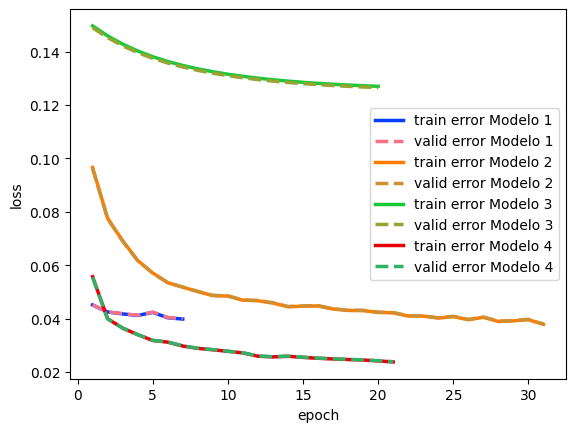

In [ ]:
grafico_error(list_models=[red_neuronal_autoencoder, red_neuronal_autoencoder_2, red_neuronal_autoencoder_3, red_neuronal_autoencoder_4])

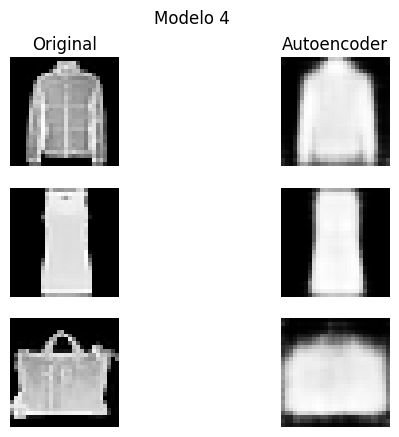

In [ ]:
red_neuronal_autoencoder_4.visualizacion(dataset=valid_set)

## Parte 3: Clasificador convolucional reutilizando el encoder

In [ ]:
# Etiquetas
labels_names = {
    0: "T-Shirt",    # Remera manga corta
    1: "Trouser",    # Pantalon
    2: "Pullover",   # Buzo
    3: "Dress",      # Vestido
    4: "Coat",       # Abrigo
    5: "Sandal",     # Sandalia
    6: "Shirt",      # Remera manga larga
    7: "Sneaker",    # Zapatilla
    8: "Bag",        # Bolso
    9: "Ankle Boot", # Bota
}

In [ ]:
# Arquitectura de la red
class NeuralNetwork_clasificador(nn.Module):
  def __init__(self, n, p=0.2, name='Modelo'):
    # Guardo atributos para saber reconocer al modelo
    self.n = n
    self.name = name

    # Atributos para ir guarando cómo se comporta la loss después de entrenar
    self.train_avg_loss_entrenamiento = []
    self.train_avg_loss_entrenada = []
    self.valid_avg_loss = []
    self.train_frac_correct_entrenamiento = []
    self.train_frac_correct_entrenada = []
    self.valid_frac_correct = []

    # Guardo los pesos por época
    self.pesos_por_epoca = {}

    # Ya hay una clase creada por pytorch y le tengo que heredar los métodos con este super, agregamos atributos (o miembros) que viene de métodos de la superclase
    super(NeuralNetwork_clasificador, self).__init__()

    # Encooder
    self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3)),  # input = 1x28x28, output = 16x26x26
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(kernel_size=(2, 2)), # output = 16x13x13

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3)), # output = 32x11x11
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(kernel_size=(2, 2)), # output = 32x5x5

            nn.Flatten(start_dim=1),  # output = 32*5*5
            nn.Linear(32*5*5, n),  # output = n
            nn.ReLU(),
            nn.Dropout(p),
        )

    # Clasificador
    self.relu = nn.ReLU()
    self.linear1 = nn.Linear(n, 10) # output = 10

  # Pasos de la arquitectura
  def forward(self, x):
    x = self.encoder(x)

    # Capa lineal del clasificador
    x = self.linear1(x)
    x = self.relu(x)

    return x

# Visualización de cómo clasifica algunos ejemplos
  def visualizacion(self, dataset, cols=3, rows=3):
    # Seleccionamos el método eval para que desactive el dropout
    self.eval()
    # Mandamos el modelo para que actué en el entorno adecuado
    self.to(device)

    # Creación de la figura
    figure = plt.figure()
    plt.suptitle(f'{self.name}')
    for i in range(1,cols*rows+1):
      # Toma ejemplos aleatorios del dataset
      j = torch.randint(len(dataset),size=(1,)).item()
      image,label = dataset[j]
      pred = self(image.unsqueeze(1).to(device))

      # Imagen original con su categoría de predicción arriba
      figure.add_subplot(rows,cols,i)
      plt.subplots_adjust(hspace=0.3)

      # Etiqueta predicha
      plt.title(labels_names[pred.argmax(1).item()])

      # Etiqueta verdadera vertical a la izquierda
      plt.text(-3.5, 12, labels_names[label], va='center', ha='center', rotation=90, fontsize=12)
      plt.axis("off")
      plt.imshow(image.squeeze(),cmap="Greys_r")

    # La guarda en el directorio
    plt.savefig(f'Ejemplo {self.name}.svg', bbox_inches='tight', pad_inches=0.1, format='svg')
    plt.show()

## Modelo 5

In [ ]:
# Creo el objeto que actuará como clasificador
red_neuronal_clasificador_5 = NeuralNetwork_clasificador(n=64, p=0.2, name='Modelo 5')

# Cargo los pesos del encoder anterior, se hace un deepcopy para que tenga diferente id de objeto
red_neuronal_clasificador_5.encoder = copy.deepcopy(red_neuronal_autoencoder.encoder)

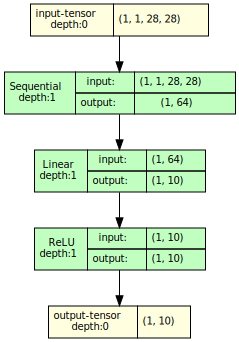

In [ ]:
# Visualización del modelo. Input_size = (1, 1, 28, 28) refiere a un ejemplo con dimensiones (1, 28, 28)
model_graph = draw_graph(model=red_neuronal_clasificador_5, input_size=(1, 1, 28, 28), expand_nested=True,
                         device=device, hide_module_functions=False, depth=1)
model_graph.visual_graph.render('estructura_clasificador', format='svg', view=True)
model_graph.visual_graph

Con la Cross Entropy Loss, al vector Y se lo puede pensar como que indique las clases (ejemplo Y=[4,2,...,1]) o que cada ejemplo sea un vector de 10 número marcando con 1 si pertenece a la clase (ejemplo Y=[[0,0,...,1], [0,1,0,...0],...])

In [ ]:
# Creamos los DataLoaders
batch_size = 100
trainloader = DataLoader(trainset , batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle = False)

# Optimizador
learning_rate = 1e-3
optimizer = torch.optim.Adam(red_neuronal_clasificador_5.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

# Loss function, entropía cruzada
loss_fn = nn.CrossEntropyLoss()

# Número de épocas
num_epochs = 40
entrenamiento_epoca(red_neuronal_clasificador_5, trainloader, valid_loader, loss_fn, optimizer, num_epochs, verbose=1, accuracy=True)

Epoch 1
-------------------------------
batch=0 loss=2.517873  muestras-procesadas:[    0/60000]
batch=150 loss=0.983492  muestras-procesadas:[15000/60000]
batch=300 loss=0.710215  muestras-procesadas:[30000/60000]
batch=450 loss=0.506714  muestras-procesadas:[45000/60000]
Training Error: 
 Accuracy: 83.4%, Avg loss: 0.517987 

Valid Error: 
 Accuracy: 82.5%, Avg loss: 0.534174 

Epoch 2
-------------------------------
batch=0 loss=0.422503  muestras-procesadas:[    0/60000]
batch=150 loss=0.575898  muestras-procesadas:[15000/60000]
batch=300 loss=0.610995  muestras-procesadas:[30000/60000]
batch=450 loss=0.363987  muestras-procesadas:[45000/60000]
Training Error: 
 Accuracy: 86.1%, Avg loss: 0.434807 

Valid Error: 
 Accuracy: 85.0%, Avg loss: 0.451954 

Epoch 3
-------------------------------
batch=0 loss=0.503667  muestras-procesadas:[    0/60000]
batch=150 loss=0.397539  muestras-procesadas:[15000/60000]
batch=300 loss=0.380671  muestras-procesadas:[30000/60000]
batch=450 loss=0.22

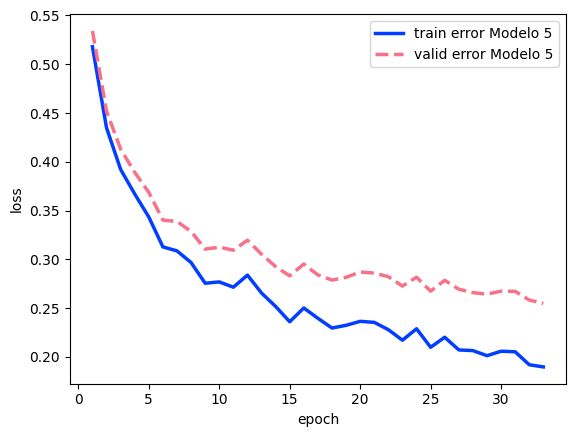

In [ ]:
grafico_error(list_models=[red_neuronal_clasificador_5])

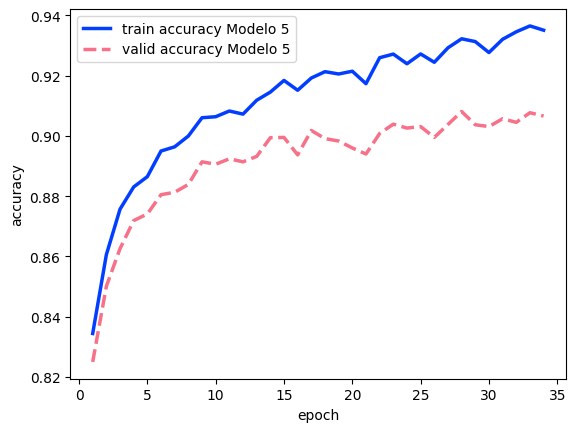

In [ ]:
grafico_accuracy(list_models=[red_neuronal_clasificador_5])

Hay sobrefiteo, tengo que elegir la época óptima

In [ ]:
# Función para restaurar pesos
def restaurar_pesos(model, epoca):
  if epoca in model.pesos_por_epoca:
      model.load_state_dict(model.pesos_por_epoca[epoca])
      model.train_avg_loss_entrenamiento = model.train_avg_loss_entrenamiento[:epoca]
      model.train_avg_loss_entrenada = model.train_avg_loss_entrenada[:epoca]
      model.valid_avg_loss = model.valid_avg_loss[:epoca]
      model.train_frac_correct_entrenamiento = model.train_frac_correct_entrenamiento[:epoca]
      model.train_frac_correct_entrenada = model.train_frac_correct_entrenada[:epoca]
      model.valid_frac_correct = model.valid_frac_correct[:epoca]
      print(f"Pesos de la época {epoca} cargados")

In [ ]:
restaurar_pesos(red_neuronal_clasificador_5, 15)

Pesos de la época 15 cargados


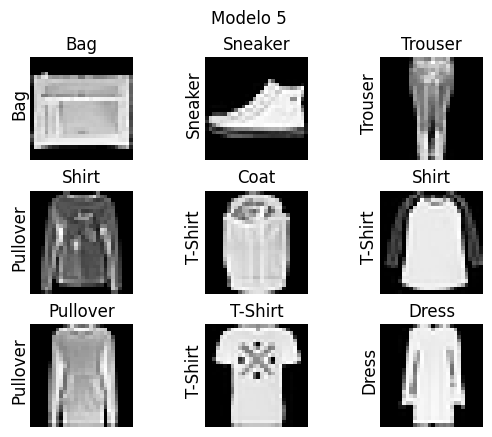

In [ ]:
red_neuronal_clasificador_5.visualizacion(dataset=validset)

In [ ]:
def matriz_confusion(model):
  y_pred = []
  y_true = []

  # iterate over test data
  for image, label in validset:
          output = model(image.unsqueeze(1).to(device))

          output = output.argmax(1).item()
          y_pred.append(output)

          y_true.append(label)

  classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)  # filas es la etiqueta verdadera y columna etiqueta predicha
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sns.heatmap(df_cm, annot=True)
  plt.ylabel('Etiquetas verdaderas')
  plt.xlabel('Etiquetas predichas')
  plt.title(f'Matriz de Confusión {model.name}')
  plt.savefig(f'Matriz de Confusión {model.name}.svg', bbox_inches='tight', pad_inches=0.1, format='svg')
  plt.show()

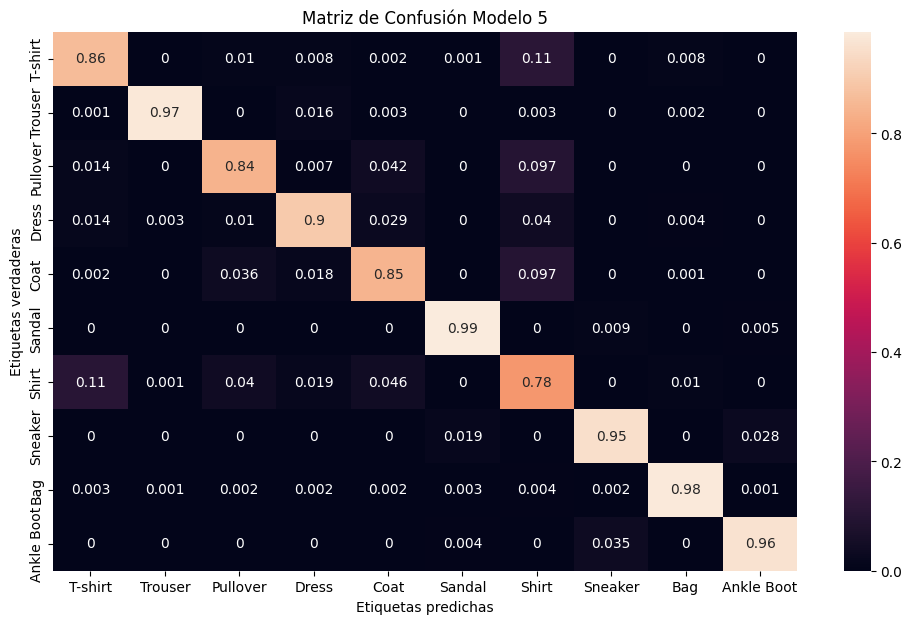

In [ ]:
matriz_confusion(red_neuronal_clasificador_5)

## Modelo 6

In [ ]:
# Creo el objeto que actuará como clasificador
red_neuronal_clasificador_6 = NeuralNetwork_clasificador(n=256, p=0.3, name='Modelo 6')

# Cargo los pesos del encoder anterior, se hace un deepcopy para que tenga diferent id de objeto
red_neuronal_clasificador_6.encoder = copy.deepcopy(red_neuronal_autoencoder_2.encoder)

In [ ]:
# Creamos los DataLoaders
batch_size = 1000
trainloader = DataLoader(trainset , batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle = False)

# Optimizador
learning_rate = 1e-3
optimizer = torch.optim.Adam(red_neuronal_clasificador_6.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

# Loss function, entropía cruzada
loss_fn = nn.CrossEntropyLoss()

# Número de épocas
num_epochs = 40
entrenamiento_epoca(red_neuronal_clasificador_6, trainloader, valid_loader, loss_fn, optimizer, num_epochs, verbose=1, accuracy=True)

Epoch 1
-------------------------------
batch=0 loss=2.334955  muestras-procesadas:[    0/60000]
batch=15 loss=0.904136  muestras-procesadas:[15000/60000]
batch=30 loss=0.707575  muestras-procesadas:[30000/60000]
batch=45 loss=0.618904  muestras-procesadas:[45000/60000]
Training Error: 
 Accuracy: 81.9%, Avg loss: 0.653854 

Valid Error: 
 Accuracy: 81.2%, Avg loss: 0.670358 

Epoch 2
-------------------------------
batch=0 loss=0.532866  muestras-procesadas:[    0/60000]
batch=15 loss=0.544166  muestras-procesadas:[15000/60000]
batch=30 loss=0.540111  muestras-procesadas:[30000/60000]
batch=45 loss=0.527538  muestras-procesadas:[45000/60000]
Training Error: 
 Accuracy: 84.2%, Avg loss: 0.568702 

Valid Error: 
 Accuracy: 83.1%, Avg loss: 0.585185 

Epoch 3
-------------------------------
batch=0 loss=0.503568  muestras-procesadas:[    0/60000]
batch=15 loss=0.530736  muestras-procesadas:[15000/60000]
batch=30 loss=0.444985  muestras-procesadas:[30000/60000]
batch=45 loss=0.467173  mue

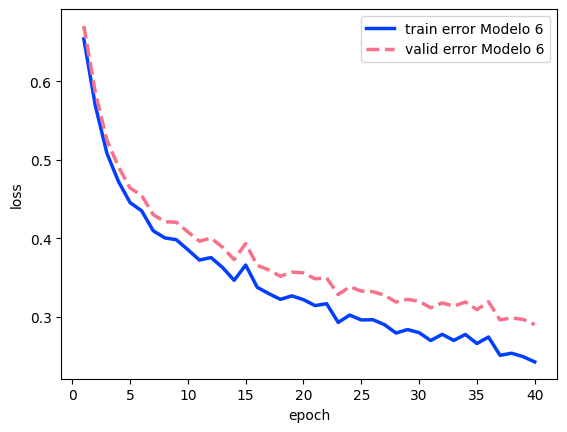

In [ ]:
grafico_error(list_models=[red_neuronal_clasificador_6])

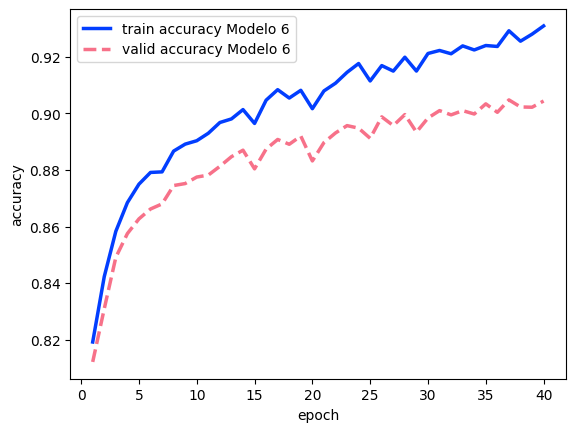

In [ ]:
grafico_accuracy(list_models=[red_neuronal_clasificador_6])

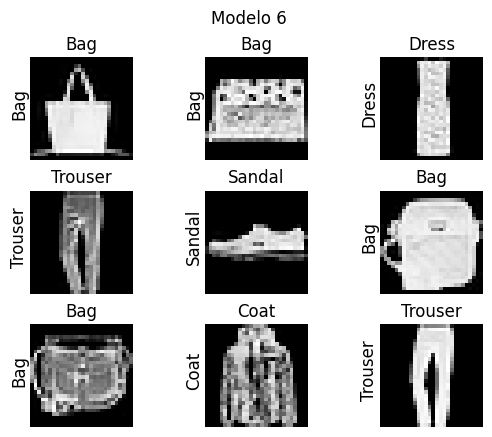

In [ ]:
red_neuronal_clasificador_6.visualizacion(dataset=validset)

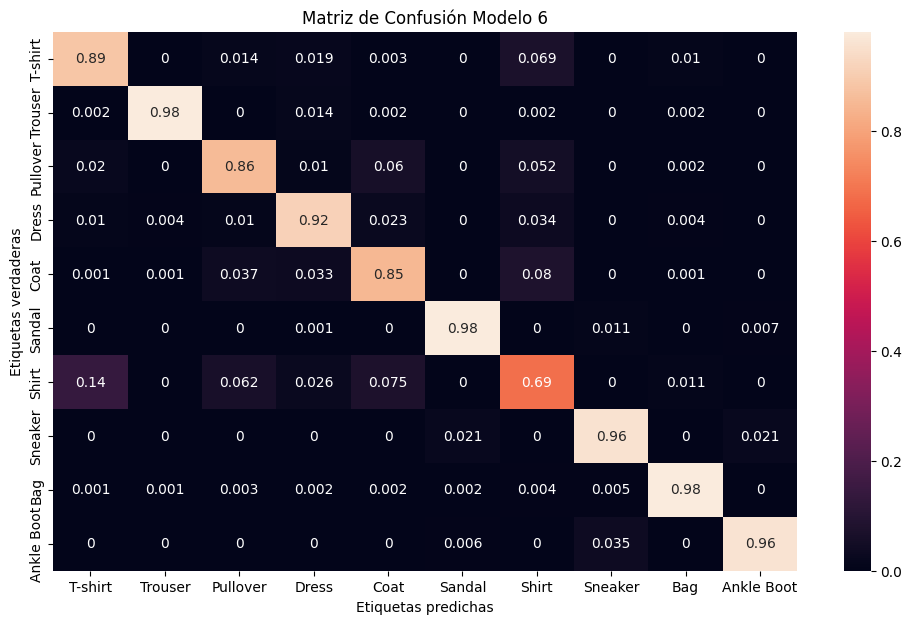

In [ ]:
matriz_confusion(red_neuronal_clasificador_6)

## Modelo 7

In [ ]:
# Creo el objeto que actuará como clasificador
red_neuronal_clasificador_7 = NeuralNetwork_clasificador(n=128, p=0.3, name='Modelo 7')

# Cargo los pesos del encoder anterior, se hace un deepcopy para que tenga diferent id de objeto
red_neuronal_clasificador_7.encoder = copy.deepcopy(red_neuronal_autoencoder_4.encoder)

In [ ]:
# Creamos los DataLoaders
batch_size = 100
trainloader = DataLoader(trainset , batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle = False)

# Optimizador
learning_rate = 1e-3
optimizer = torch.optim.Adam(red_neuronal_clasificador_7.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

# Loss function, entropía cruzada
loss_fn = nn.CrossEntropyLoss()

# Número de épocas
num_epochs = 40
entrenamiento_epoca(red_neuronal_clasificador_7, trainloader, valid_loader, loss_fn, optimizer, num_epochs, verbose=1, accuracy=True)

Epoch 1
-------------------------------
batch=0 loss=3.260957  muestras-procesadas:[    0/60000]
batch=150 loss=0.753002  muestras-procesadas:[15000/60000]
batch=300 loss=0.772640  muestras-procesadas:[30000/60000]
batch=450 loss=0.426608  muestras-procesadas:[45000/60000]
Training Error: 
 Accuracy: 83.8%, Avg loss: 0.567166 

Valid Error: 
 Accuracy: 82.5%, Avg loss: 0.581645 

Epoch 2
-------------------------------
batch=0 loss=0.400330  muestras-procesadas:[    0/60000]
batch=150 loss=0.480177  muestras-procesadas:[15000/60000]
batch=300 loss=0.501484  muestras-procesadas:[30000/60000]
batch=450 loss=0.381600  muestras-procesadas:[45000/60000]
Training Error: 
 Accuracy: 85.8%, Avg loss: 0.461077 

Valid Error: 
 Accuracy: 84.6%, Avg loss: 0.478374 

Epoch 3
-------------------------------
batch=0 loss=0.441639  muestras-procesadas:[    0/60000]
batch=150 loss=0.475608  muestras-procesadas:[15000/60000]
batch=300 loss=0.363665  muestras-procesadas:[30000/60000]
batch=450 loss=0.33

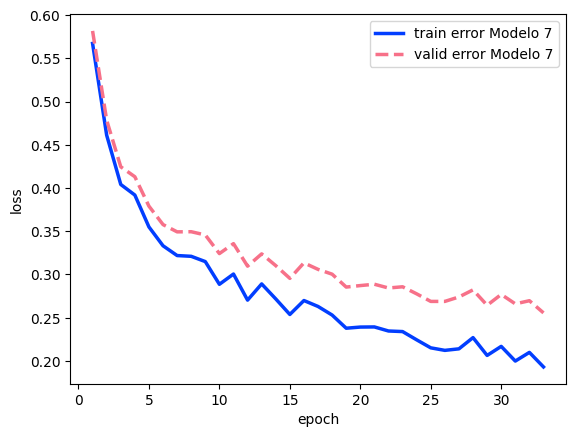

In [ ]:
grafico_error(list_models=[red_neuronal_clasificador_7])

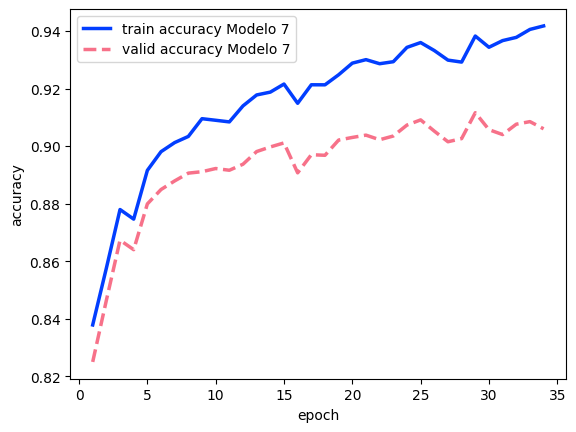

In [ ]:
grafico_accuracy(list_models=[red_neuronal_clasificador_7])

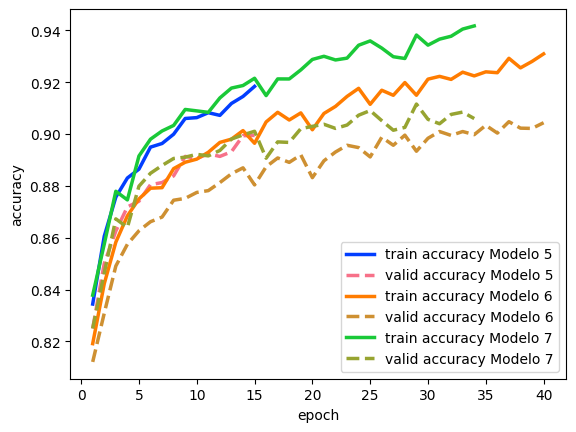

In [ ]:
grafico_accuracy(list_models=[red_neuronal_clasificador_5, red_neuronal_clasificador_6, red_neuronal_clasificador_7])

Hay sobreajuste, se tiene que analizar cuál es la época óptima

In [ ]:
# Se restaura de la época 19
restaurar_pesos(red_neuronal_clasificador_7, 19)

Pesos de la época 19 cargados


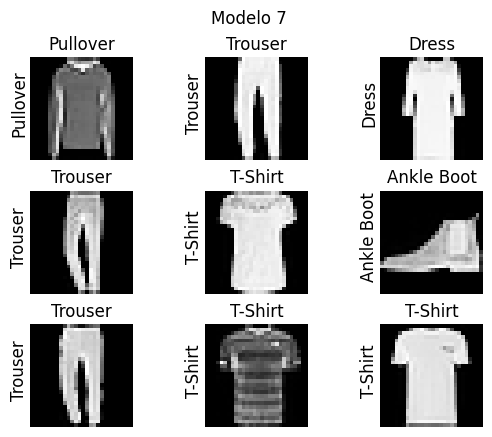

In [ ]:
red_neuronal_clasificador_7.visualizacion(dataset=validset)

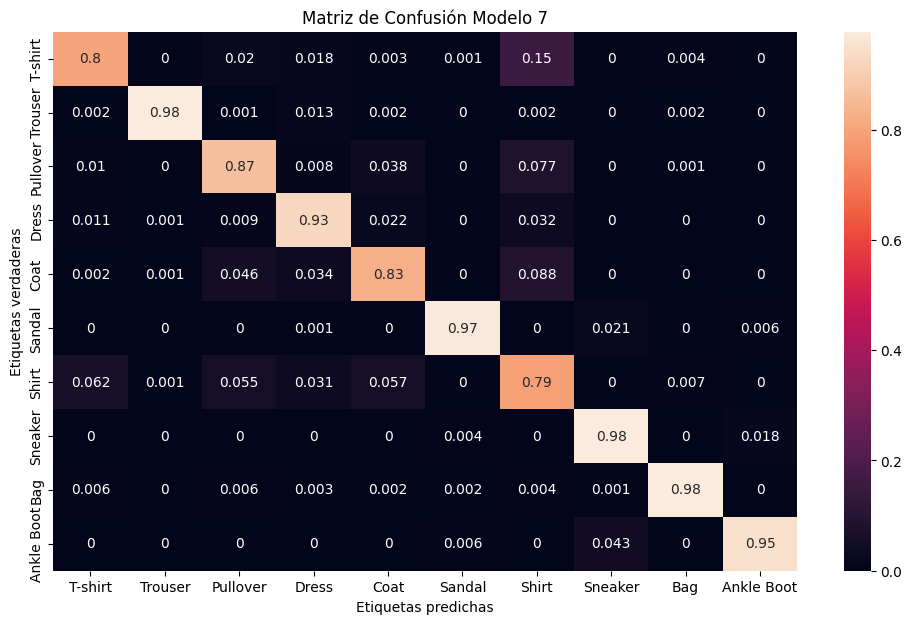

In [ ]:
matriz_confusion(red_neuronal_clasificador_7)

## Modelo 8

IMPORTANTE: CrossEntropyLoss() in PyTorch internally computes softmax. NO SE TIENE PONER SOFTMAX como final activation function. Altenartiva: cambiar la loss por nn.NLLLoss() y usar nn.LogSoftmax(dim=1) como función de activación. <br>
¿Por qué no se pone de nuevo Softmax? Al aplciar la primera vez la softmax, los valores varían entre 0 y 1 y están más cerquitas de lo que sin aplicar estaban. Si se aplica de nuevo la softmax, los aceracaría aún más,
produciendo así errores mayores al calcular la loss.

In [ ]:
# Heredo todo de la clase NeuralNetwork_clasificador
class NeuralNetwork_clasificador_2(NeuralNetwork_clasificador):
  def __init__(self, n, p=0.2, name='Modelo'):
    NeuralNetwork_clasificador.__init__(self, n, p, name)

    self.clasificador = nn.Sequential(nn.Linear(n, 10)#,
                                 #nn.LogSoftmax(dim=1)
                                )

  # Pasos de la arquitectura
  def forward(self, x):
    x = self.encoder(x)

    x = self.clasificador(x)

    return x

In [ ]:
# Creo el objeto que actuará como clasificador
red_neuronal_clasificador_8 = NeuralNetwork_clasificador_2(n=128, p=0.3, name='Modelo 8')

# Cargo los pesos del encoder anterior, se hace un deepcopy para que tenga diferent id de objeto
red_neuronal_clasificador_8.encoder = copy.deepcopy(red_neuronal_autoencoder_4.encoder)

In [ ]:
# Creamos los DataLoaders
batch_size = 1000
trainloader = DataLoader(trainset , batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle = False)

# Optimizador
learning_rate = 1e-3
# Entreno sólo el decoder, el encoder lo dejo fijo
optimizer = torch.optim.Adam(red_neuronal_clasificador_8.clasificador.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

# Loss function, entropía cruzada
#loss_fn = nn.NLLLoss()
loss_fn = nn.CrossEntropyLoss()

# Número de épocas
num_epochs = 40
entrenamiento_epoca(red_neuronal_clasificador_8, trainloader, valid_loader, loss_fn, optimizer, num_epochs, verbose=1, accuracy=True)

Epoch 1
-------------------------------
batch=0 loss=3.646852  muestras-procesadas:[    0/60000]
batch=15 loss=2.233108  muestras-procesadas:[15000/60000]
batch=30 loss=1.554842  muestras-procesadas:[30000/60000]
batch=45 loss=1.281617  muestras-procesadas:[45000/60000]
Training Error: 
 Accuracy: 71.3%, Avg loss: 1.142771 

Valid Error: 
 Accuracy: 70.9%, Avg loss: 1.153052 

Epoch 2
-------------------------------
batch=0 loss=1.030508  muestras-procesadas:[    0/60000]
batch=15 loss=0.948348  muestras-procesadas:[15000/60000]
batch=30 loss=0.928676  muestras-procesadas:[30000/60000]
batch=45 loss=0.884860  muestras-procesadas:[45000/60000]
Training Error: 
 Accuracy: 77.1%, Avg loss: 0.934995 

Valid Error: 
 Accuracy: 76.5%, Avg loss: 0.947615 

Epoch 3
-------------------------------
batch=0 loss=0.837754  muestras-procesadas:[    0/60000]
batch=15 loss=0.803998  muestras-procesadas:[15000/60000]
batch=30 loss=0.784929  muestras-procesadas:[30000/60000]
batch=45 loss=0.773407  mue

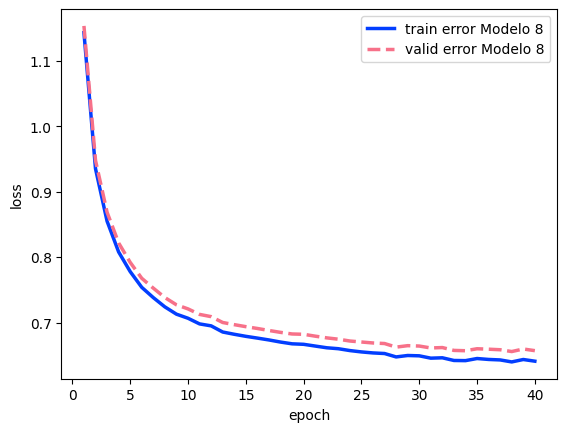

In [ ]:
grafico_error(list_models=[red_neuronal_clasificador_8])

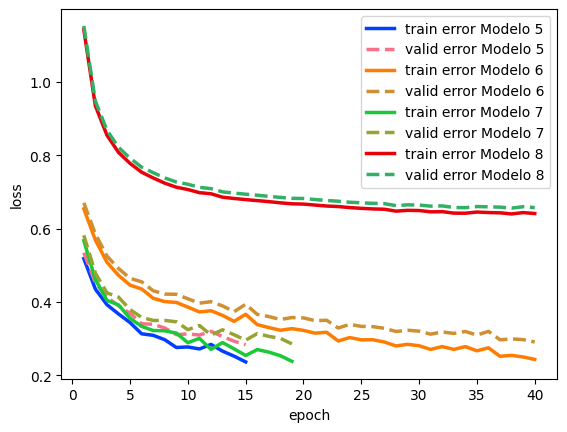

In [ ]:
grafico_error(list_models=[red_neuronal_clasificador_5, red_neuronal_clasificador_6, red_neuronal_clasificador_7, red_neuronal_clasificador_8])

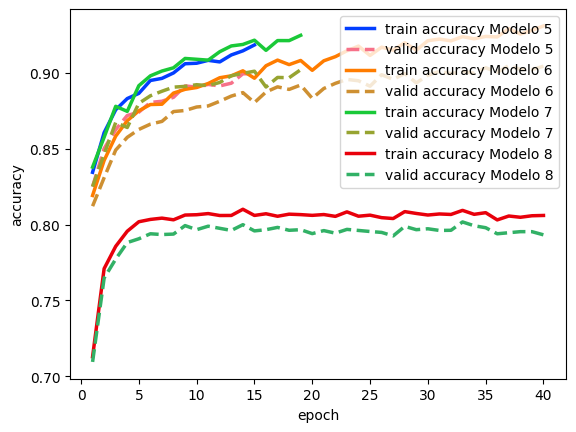

In [ ]:
grafico_accuracy(list_models=[red_neuronal_clasificador_5, red_neuronal_clasificador_6, red_neuronal_clasificador_7, red_neuronal_clasificador_8])

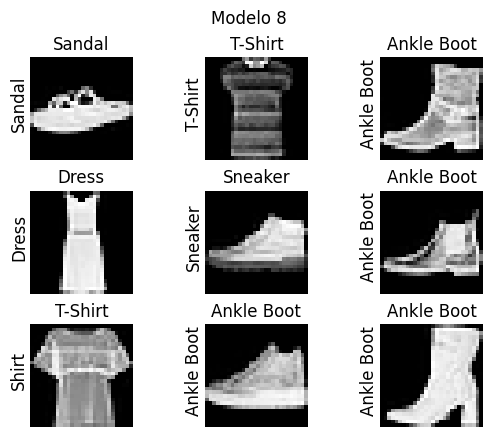

In [ ]:
red_neuronal_clasificador_8.visualizacion(dataset=validset)

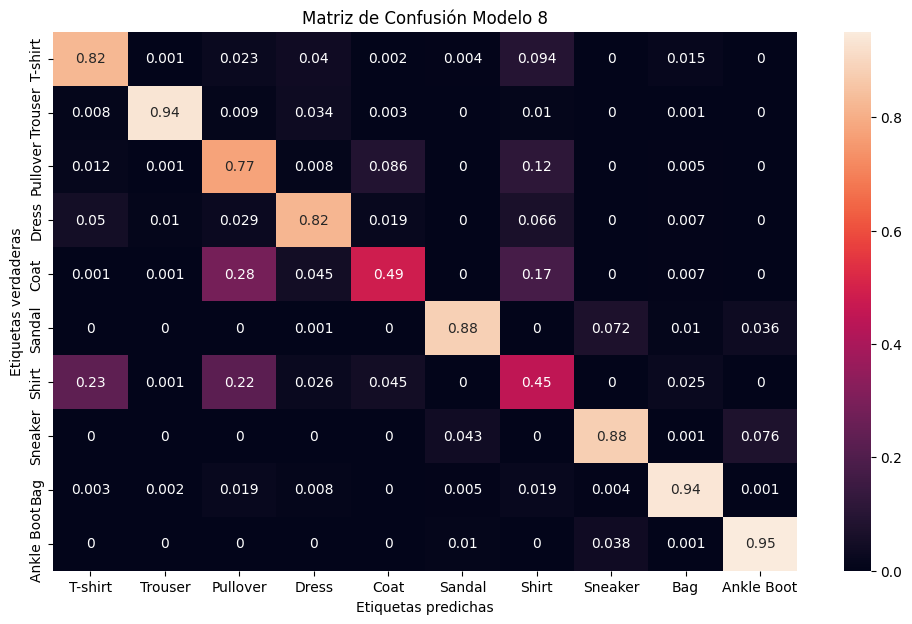

In [ ]:
matriz_confusion(red_neuronal_clasificador_8)